# XGBoost

In [38]:
import pandas as pd
import pylab as plt
import numpy as np
import scipy.optimize as opt
from sklearn.preprocessing import LabelEncoder, StandardScaler
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

In this notebook we explore XGBoost, using the open source library for fitting a boosted model. As usual with more complex models, they can cause overfitting and as such hyperparameter tuning is required. Here we will use XGB with DecisionTreeClassifiers.

Gradient Boosting is a learning method where a number of weak learners are combined.

In [10]:
## HELPER FUNCTIONS
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return {
        "test Accuracy":
            metrics.accuracy_score(y_test, model.predict(X_test)),
        "train Accuracy": 
            metrics.accuracy_score(y_train, model.predict(X_train))
        }

def get_accuracy_boost(X, y, title, times=20, xlabel='Number Estimators', learning_rate=[0.2,0.4,0.6,1], n_est = 100, objective='binary:logistic'):

    lines_array=['solid','--', '-.', ':']

    N_estimators=[n*2 for n in range(1,n_est//2)]
    
    train_acc=np.zeros((times,len(learning_rate),len(N_estimators)))
    test_acc=np.zeros((times,len(learning_rate),len(N_estimators)))

    #Iterate through different number of Learning rate  and average out the results  
    for n in tqdm(range(times)):
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)
        for n_estimators in N_estimators:
            for j,lr in enumerate(learning_rate):

                model = XGBClassifier(objective=objective,learning_rate=lr,n_estimators=n_estimators,eval_metric='mlogloss')
                model.fit(X_train,y_train)

                Accuracy=get_accuracy(X_train, X_test, y_train, y_test,  model)

                train_acc[n,j,(n_estimators//2)-1]=Accuracy['train Accuracy']
                test_acc[n,j,(n_estimators//2)-1]=Accuracy['test Accuracy']
    
    fig, ax1 = plt.subplots()
    mean_test=test_acc.mean(axis=0)
    mean_train=train_acc.mean(axis=0)
    ax2 = ax1.twinx()

    for j,(lr,line) in enumerate(zip(learning_rate,lines_array)): 

        ax1.plot(mean_train[j,:],linestyle = line,color='b',label="Learning rate "+str(lr))
        ax2.plot(mean_test[j,:],linestyle = line, color='r',label=str(lr))

    ax1.set_ylabel('Training accuracy',color='b')
    ax1.legend()
    ax2.set_ylabel('Testing accuracy', color='r')
    ax2.legend()
    ax1.set_xlabel(xlabel)
    plt.title(title)
    plt.show()

## The Data

The data is once again the telecommunications customer churn dataset.

In [6]:
df = pd.read_csv("./data/ChurnData.csv")

features = ['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'callcard', 'wireless']
target = 'churn'

X = df[features]
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1)

In [7]:
n_estimators = 5
random_state = 0
objective = 'binary:logistic'
lr = 0.1

model = XGBClassifier(
    objective=objective,
    learning_rate=lr,
    n_estimators=n_estimators,
    eval_metric='mlogloss'
    )

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.7666666666666667, 'train Accuracy': 0.7785714285714286}


Decent performance, but we can do better, slightly changing the learning rate already shows improvement.

In [8]:
lr = 0.3

model = XGBClassifier(
    objective=objective,
    learning_rate=lr,
    n_estimators=n_estimators)

model.fit(X_train, y_train)
print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.8, 'train Accuracy': 0.9071428571428571}


Our helper function can show how the accuracy depends on the number of estimators and the learning rate:

100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


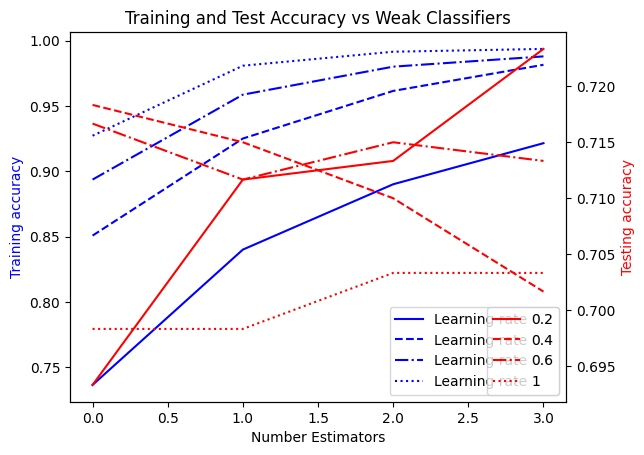

In [11]:
get_accuracy_boost(
    X,
    y,
    title="Training and Test Accuracy vs Weak Classifiers",
    times=10,
    xlabel='Number Estimators', 
    n_est = 10,
    objective='binary:logistic'
    )

## Evaluation Metrics

[0]	validation_0-error:0.23333
[1]	validation_0-error:0.18333
[2]	validation_0-error:0.16667
[3]	validation_0-error:0.16667
[4]	validation_0-error:0.20000
[5]	validation_0-error:0.16667
[6]	validation_0-error:0.21667
[7]	validation_0-error:0.20000
[8]	validation_0-error:0.18333
[9]	validation_0-error:0.18333
[10]	validation_0-error:0.20000
[11]	validation_0-error:0.18333
[12]	validation_0-error:0.20000
[13]	validation_0-error:0.21667
[14]	validation_0-error:0.21667
[15]	validation_0-error:0.23333
[16]	validation_0-error:0.21667
[17]	validation_0-error:0.23333
[18]	validation_0-error:0.25000
[19]	validation_0-error:0.23333
[20]	validation_0-error:0.23333
[21]	validation_0-error:0.20000
[22]	validation_0-error:0.20000
[23]	validation_0-error:0.20000
[24]	validation_0-error:0.20000
[25]	validation_0-error:0.21667
[26]	validation_0-error:0.21667
[27]	validation_0-error:0.21667
[28]	validation_0-error:0.23333
[29]	validation_0-error:0.23333
[30]	validation_0-error:0.23333
[31]	validation_0-

Text(0, 0.5, 'Misclassified Samples')

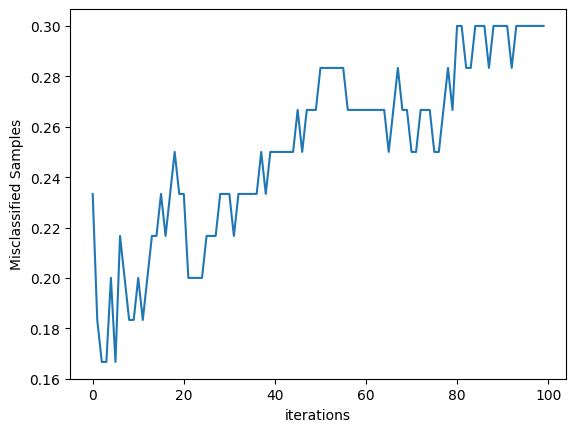

In [14]:
eval_metric = "error"
eval_set = [(X_test, y_test)]
model = XGBClassifier(eval_metric=eval_metric)
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)
results = model.evals_result()
print(results)

plt.plot(range(0, len(results['validation_0']['error'])), results['validation_0']['error'])
plt.xlabel('iterations')
plt.ylabel('Misclassified Samples')

In [21]:
eval_metric='logloss'
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set,verbose=False)
results=model.evals_result()
results.keys()

dict_keys(['validation_0', 'validation_1'])

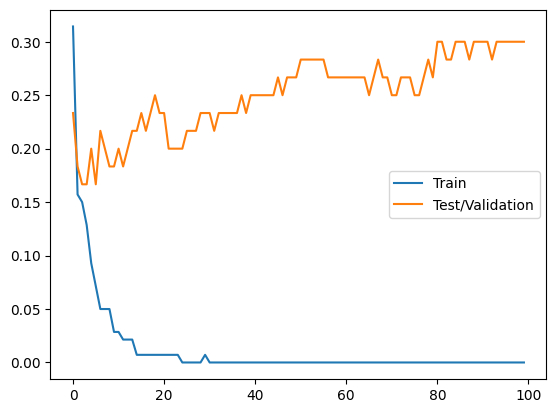

In [20]:
fig, ax = plt.subplots()
ax.plot( results['validation_0']['error'], label='Train')
ax.plot( results['validation_1']['error'], label='Test/Validation')
ax.legend()
plt.show()

This clearly shows that the model is overfitting after a few steps. We can counteract this by stopping the training early.

In [24]:
early_stopping_rounds = 10
eval_set = [(X_test, y_test)]
eval_metric='logloss'
model = XGBClassifier(eval_metric=eval_metric, early_stopping_rounds=early_stopping_rounds)
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)
print(get_accuracy(X_train, X_test, y_train, y_test,  model))

[0]	validation_0-logloss:0.50042
[1]	validation_0-logloss:0.47489
[2]	validation_0-logloss:0.45973
[3]	validation_0-logloss:0.44624
[4]	validation_0-logloss:0.44501
[5]	validation_0-logloss:0.44348
[6]	validation_0-logloss:0.43797
[7]	validation_0-logloss:0.44364
[8]	validation_0-logloss:0.44285
[9]	validation_0-logloss:0.44259
[10]	validation_0-logloss:0.44687
[11]	validation_0-logloss:0.44503
[12]	validation_0-logloss:0.45589
[13]	validation_0-logloss:0.46858
[14]	validation_0-logloss:0.47878
[15]	validation_0-logloss:0.48676
[16]	validation_0-logloss:0.49037
{'test Accuracy': 0.7833333333333333, 'train Accuracy': 0.95}


## Tree parametrisation and regularisation

In [29]:
objective = 'binary:logistic'
learning_rate = 0.1
n_estimators = 10
# Limit tree depth
max_depth = 3
# Limit least amount of node samplkes
min_child_weight = 4
# Regularization control
gamma = 1
reg_lambda = 2
alpha = 1

model = XGBClassifier(
    objective=objective,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    eval_metric='mlogloss',
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    alpha=alpha,
    reg_lambda=reg_lambda,
    gamma=gamma
    )

model.fit(X_train, y_train)
print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.7833333333333333, 'train Accuracy': 0.7785714285714286}


## Boosting on Cancer data with GridSearchCV

In [ ]:
df = pd.read_csv("./data/cell_samples.csv")
df= df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]

features = ['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']
target = 'Class'

X = df[features].astype(int)
y = df[target].map(lambda v: {2: 0, 4: 1}[v])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

model = XGBClassifier(objective='binary:logistic', eval_metric='mlogloss')

param_grid = {
    'learning_rate': 
        [0.1*(n+1) for n in range(5)],
    'n_estimators': 
        [2*n+1 for n in range(5)]
    }

search = GridSearchCV(estimator=model, param_grid=param_grid, scoring="neg_log_loss")
search.fit(X_train, y_train)

search.best_score_, search.best_params_

(np.float64(-0.10968703555523558), {'learning_rate': 0.4, 'n_estimators': 9})

In [36]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.9635036496350365, 'train Accuracy': 0.989010989010989}


## Practice drugs

In [63]:
df = pd.read_csv("./data/drug200.csv")

features = ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']
target = 'Drug'

X = df[features]
y = df[target]

le_drug = LabelEncoder()
y = le_drug.fit_transform(y).astype(int)

le_sex = LabelEncoder()
X.loc[:, 'Sex'] = le_sex.fit_transform(X['Sex'])

le_BP = LabelEncoder()
X.loc[:, 'BP'] = le_BP.fit_transform(X['BP'])

le_Chol = LabelEncoder()
X.loc[:, 'Cholesterol'] = le_Chol.fit_transform(X['Cholesterol'])

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [65]:
model = XGBClassifier(
    objective = 'binary:logistic',
    eval_metric = 'mlogloss'
)

param_grid = {
    'learning_rate': [0.1*(n+1) for n in range(2)],
    'n_estimators' : [2*n+1 for n in range(2)] 
    }

search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'neg_log_loss',
    cv = 3
)

search.fit(X_train, y_train)

search.best_score_, search.best_params_

(np.float64(-0.7904353082990503), {'learning_rate': 0.2, 'n_estimators': 3})

In [66]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.85, 'train Accuracy': 0.99375}


## Gradient Boosting Details

Let's try to sketch   how Gradient Boosting works like any supervised problem we have a dataset  ${(x_1, y_1), ..., (x_N,; y_N)} $, the strong classifier $H_{T}(x)$  is a linear combination of $T$  weak classifiers $h_t(x)$  usually trees and $\alpha_t$  is a constant in many cases $\alpha_t=1$  . Although each classifier $h_t(x)$ appears independent, the  contains information about the error of classifiers from $h_1(x),.., h_{t}(x)$.

$H_{T}(\mathbf{x}) = \sum_{t=1}^T \alpha_t h_t(\mathbf{x}) $

Borrowing the notation form [Kilian Weinberger](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote19.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01) , we have a the cost function:

$\ell(H)=\frac{1}{n}\sum_{i=1}^n \ell(H_{T}(\mathbf{x}_i),y_i)$

Where $\ell$ convex i.e bole shape shown below and differentiable, such as derivative exists.

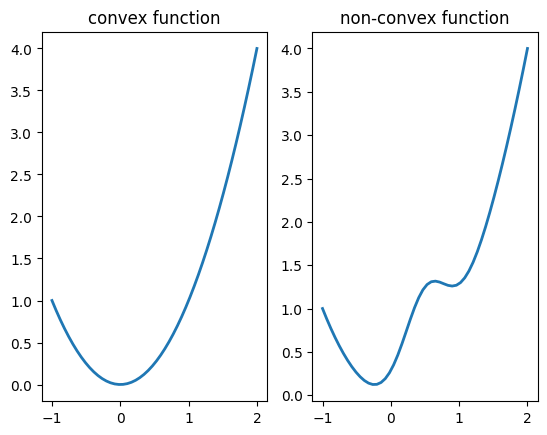

In [ ]:
x = np.linspace(-1, 2)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, x**2, linewidth=2)
ax1.set_title('convex function')
ax2.plot(x, x**2 + np.exp(-5*(x - .5)**2), linewidth=2)
ax2.set_title('non-convex function')
plt.show()

If you're familiar with cost functions, this may seem strange as we are dealing with a function of $H$ not of parameters. Ideally would like to minimize the cost for  $h_{T}(\mathbf{x})$  and  $H_{T-1}(\mathbf{x})$ at the same time   , but this is difficult. So we minimize the cost with respect to   $h_{T}(\mathbf{x})$  while keeping $H_{T-1}(\mathbf{x})$ fixed; not only is this simpler it prevents overfitting.

$h_{t}(x) = 	extrm{argmin}_{   h \in \mathbb{H}} \sum_{i=1}^n \ell(  H_{t-1}(\mathbf{x}_i) + \gamma h_t(\mathbf{x}_i),y_i)$  (1)

Usually $\gamma$  is selected using validation data, but in some cases, like AdaBoost, you can find  the expression for the  optimal value of $\gamma$.

### How to Minimize Cost

We would like to find the value of classifier $h_{t}(x)$ in red  that minimises the Cost function in (1), this is difficult so we minimize the first order Taylor Approximation as shown in (2). We see that it is only a function of the second term in red.

$\ell(H+\alpha h)\approx\ell(H)+ \gamma \sum_{i = 1}^{n} r_{i,t-1} h_{t}(\mathbf{x}_i)$ (2)

$r_{i,t-1}=\frac{\partial \ell}{\partial [H_{t-1}(\mathbf{x}_i)]}$

An example of Taylor Approximation is shown in the following figure, the true cost function is in blue and the first Taylor Approximation is in Orange.

<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Florian-Music\AppData\Local\Temp\ipykernel_23124\11839327.py:2: SyntaxWarning: invalid escape sequence '\e'
  plt.text(-.7, 3, '$ \ell(H_{T}+h_{t},y_i)$', size=20)


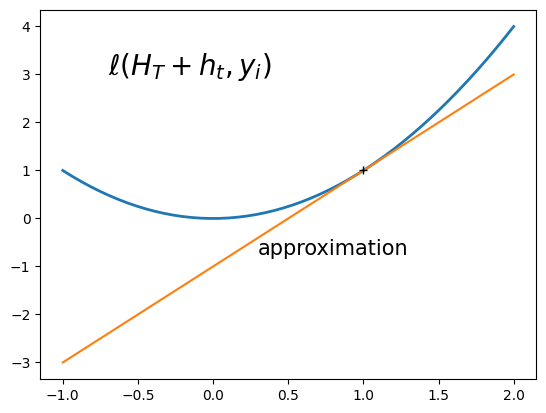

In [68]:
plt.plot(x, x**2, linewidth=2)
plt.text(-.7, 3, '$ \ell(H_{T}+h_{t},y_i)$', size=20)
plt.plot(x, 2*x - 1)
plt.plot(1, 1, 'k+')
plt.text(.3, -.75, 'approximation', size=15)
plt.show()

### Example with Python

This all seems a little confusing so let’s do a simple example with the Root mean square error loss are write the Python code. This is not usually used for regression but can be used for classification and  the math is relatively  simple to understand. First we calculate $r_{i}$:

$ \ell(H) =\sum_{i=1}^n (r_{i,t-1}-  H_{t-1}(\mathbf{x}_i))^{2} $

$ r_{i,t}=\frac{\partial \ell}{\partial [H_{T-1}(\mathbf{x}_i)]}=2\sum_{i=1}^n ( r_{i,t-1}-  H_{T-1}(\mathbf{x}_i))$

Then we plug it into equation 3; with some math, we get the following expression below, just a note these steps are not as simple as they look, so check out [Kilian Weinberger](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote19.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01) for more details.

$h_{t}(x) =	extrm{argmin}_{h \in \mathbb{H}}{ \sum_{i = 1}^{n} r_{i,t} \color{red}{h_{t}(\mathbf{x}_i)}}$

$=	extrm{argmin}_{h \in \mathbb{H}}{ \sum_{i = 1}^{n} 2\sum_{i=1}^n (y_i-  H_{T-1}(\mathbf{x}_i)) \color{red}{h_{T}(\mathbf{x}_i)}}$

$=	extrm{argmin}_{h \in \mathbb{H}}{ \sum_{i = 1}^{n} (r_{i,t}^{2}- {h_{t}(\mathbf{x}_i)})^{2}}$

Let’s go through a few iterations; at the same time implement the algorithm with  Python. For the Python portion we will use the Toy data where the class of y is as following $y=0$ if $ 0<x<1$ else if  $y=1$, $1 \leq x< 2$ else $y=3$.


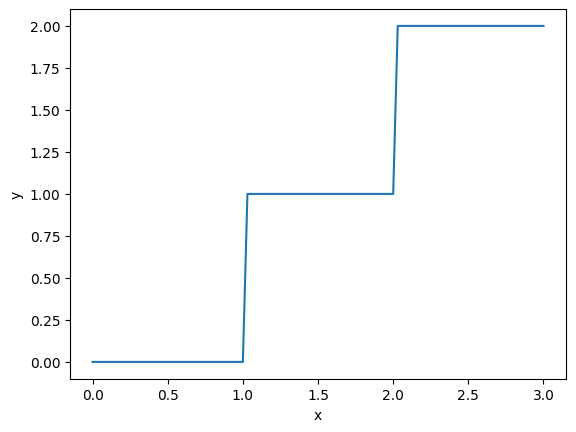

In [69]:
X=np.linspace(0, 3,num=100)
 
y=np.zeros(X.shape)
y[X>1]=1
y[X>2]=2
plt.plot(X,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

For the first iteration we start off with $h_1(\mathbf{x})$ minimizing the original labels $y_{i}$ that equals $r_{i,1}$.

$h_{1}(x)=	extrm{argmin}_{h \in \mathbb{H}}{ \sum_{i = 1}^{n} (y_{i}- {h_{1}(\mathbf{x}_i)})^{2}}$

All this means is we apply any algorithm with the cost function in the same form to the data. One constraint is  $h$ has to be non-linear, in Python:

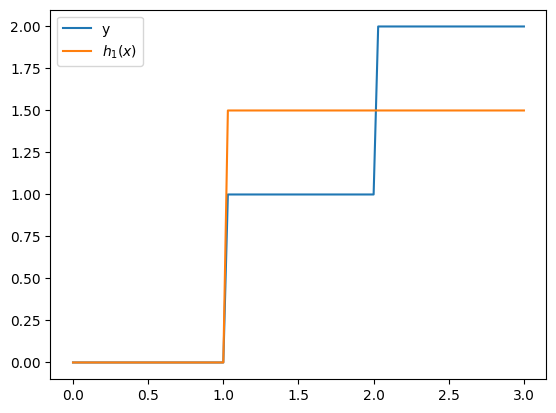

In [71]:
reg = DecisionTreeRegressor(max_depth=1)
reg.fit(X.reshape(-1,1),y)
h_1=reg.predict(X.reshape(-1,1))

plt.plot(X,y,label="y")
plt.plot(X,h_1,label="$h_{1}(x)$")
plt.legend()
plt.show()

For the second step  we set  $H_{1}(\mathbf{x})=h_{1}(\mathbf{x})$,then we calculate $r_{i,2}$.

$ r_{i,2}=( r_{i,1}-  H_{1}(\mathbf{x}_i))$

In [72]:
gamma=1
r=y-gamma*reg.predict(X.reshape(-1,1))

We then find the second learner $h_{2}(\mathbf{x})$ by minimizing

$h_{2}(x)=	extrm{argmin}_{h \in \mathbb{H}}{ \sum_{i = 1}^{n} (r_{i,2}^{2}- {h_{2}(\mathbf{x}_i)})^{2}}$

We then update $H_{2} (\mathbf{x})= H_{1} (\mathbf{x})+ \gamma h_{2}(\mathbf{x})$

We repeat the process for $ t$ times:

$h_{t}(x)=	extrm{argmin}_{h \in \mathbb{H}}{ \sum_{i = 1}^{n} (r_{i,t}^{2}- {h_{t}(\mathbf{x}_i)})^{2}}$

We then update $H_{t} (\mathbf{x})= H_{t-1} (\mathbf{x}) + \gamma h_{t}(\mathbf{x})$

We can perform the Operation with a loop in Python. First, we will write a function to make a prediction using an input of a list of predictors `weak_learners`.

In [73]:
def predict(y,weak_learners,gamma):
    yhat=np.zeros(y.shape)
    for h in weak_learners:
        yhat+=h.predict(X.reshape(-1,1))
    return yhat

Then we train a new weak learner recursively setting gamma=1, and plot the results for each iteration.

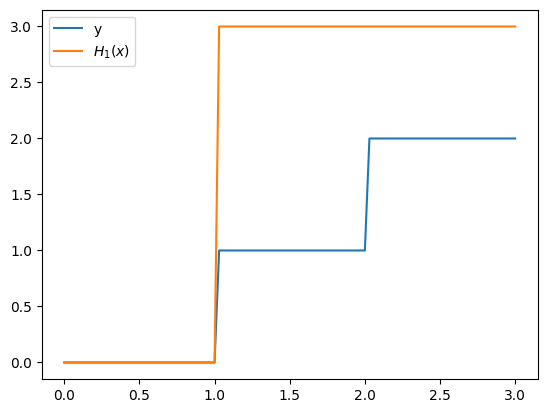

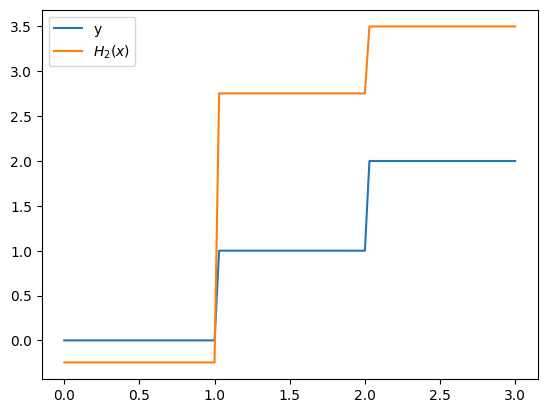

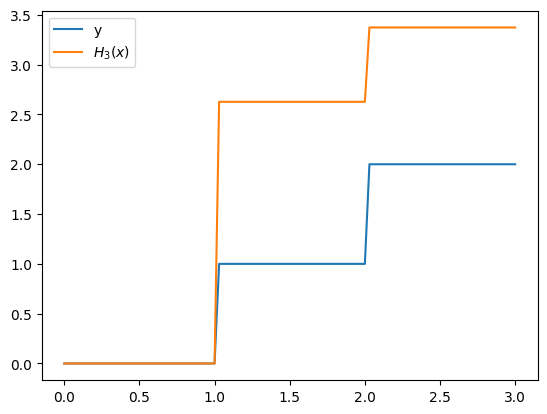

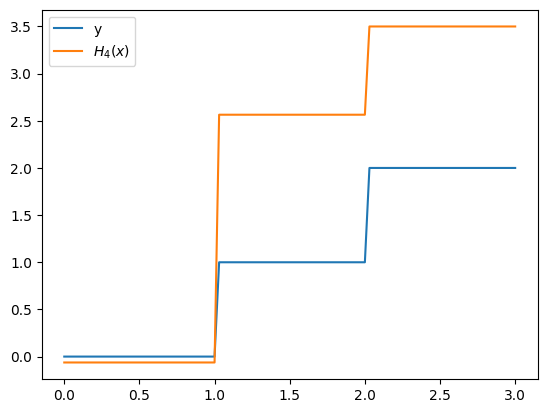

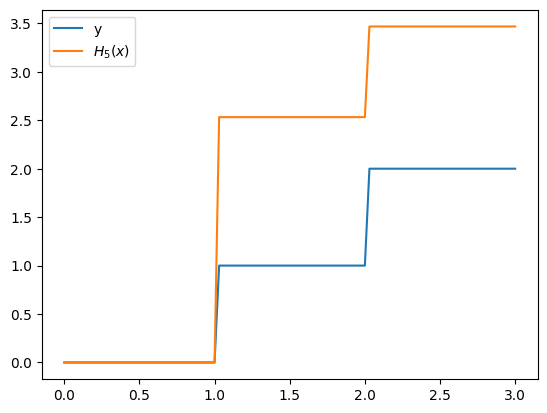

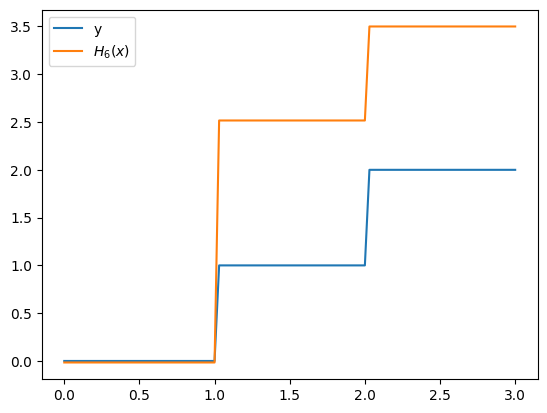

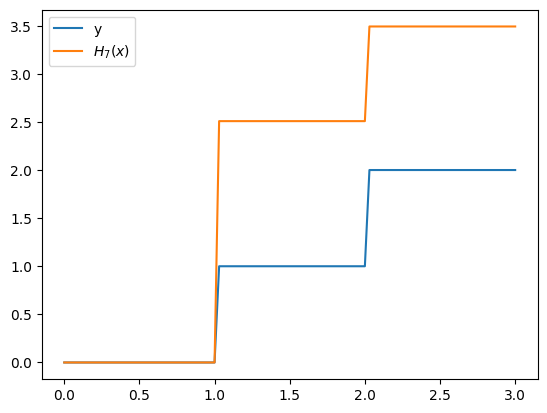

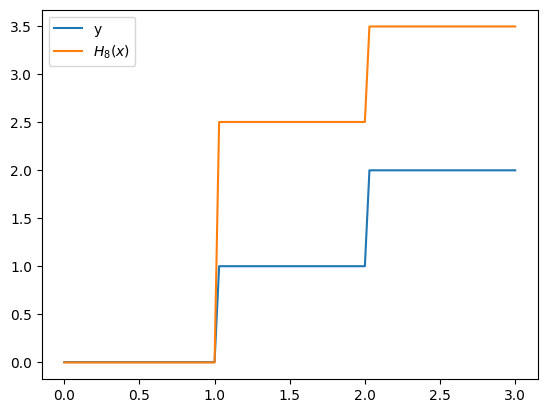

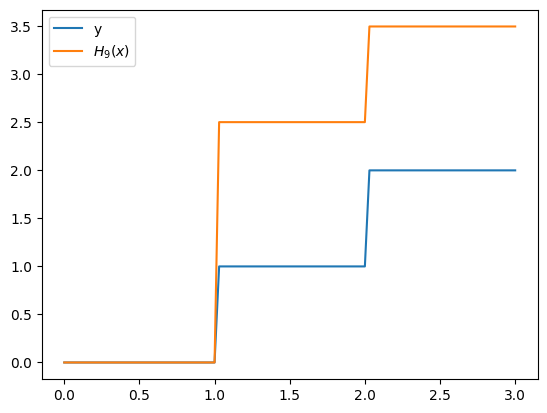

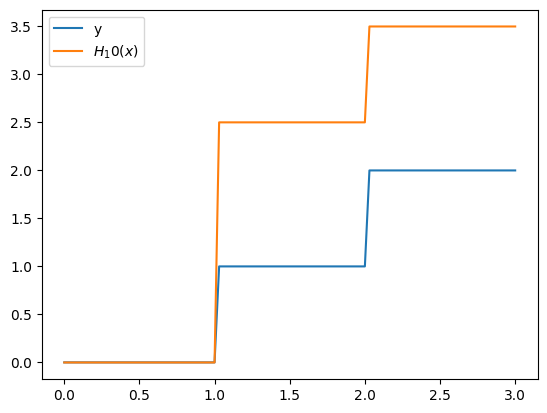

In [74]:
weak_learners =[]
gamma=1
r=y
weak_learners.append(reg)
for t_ in range(0,10):
    #train weak learner 
    reg=DecisionTreeRegressor(max_depth=1)
    reg.fit(X.reshape(-1,1),r)
    weak_learners.append(reg)
    
    #Calculate r_i,t for each iteration  
    r=r-gamma*reg.predict(X.reshape(-1,1))
    #plot function   
    plt.plot(X,y,label="y")
    plt.plot(X,predict (y,weak_learners,gamma),label="$H_{}(x)$".format(t_+1))
    plt.legend()
    plt.show()